In [ ]:
# Initialize Modin and Joblib for parallel and distributed processing
import os
os.environ["MODIN_ENGINE"] = "ray"  # Use Ray as Modin backend
import modin.pandas as pd
import joblib
import warnings
warnings.filterwarnings('ignore')

# Now, use 'pd' as you would with pandas, but with distributed execution

# Parallel and Distributed Data Processing with Modin and Joblib
This notebook leverages Modin and Joblib libraries to accelerate data processing and model training:

- **Modin** is used as a drop-in replacement for pandas to enable distributed and parallel data manipulation, making it possible to process large datasets efficiently across multiple CPU cores or clusters.
- **Joblib** is used to parallelize model training and evaluation, enabling efficient use of computational resources during machine learning workflows.

To use Modin, simply replace `import pandas as pd` with `import modin.pandas as pd`. Modin can be configured to run on Ray or Dask backends for distributed execution.

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

ton_iot = pd.read_csv('NF-ToN-IoT-v2.csv')


In [3]:
ton_iot.shape

(16940496, 45)

### Deletes features from 

In [4]:
categorical_feature = ['L4_SRC_PORT','L4_DST_PORT','IPV4_SRC_ADDR',
                       'IPV4_DST_ADDR','PROTOCOL','L7_PROTO','DNS_QUERY_TYPE','ICMP_TYPE'
                        ,'ICMP_IPV4_TYPE','DNS_TTL_ANSWER']

not_used = ['DNS_QUERY_ID','FTP_COMMAND_RET_CODE']

tagets = ['Attack','Label']

to_drop_corr_col = ['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS']

to_drop_VIF = ['NUM_PKTS_1024_TO_1514_BYTES', 'CLIENT_TCP_FLAGS']

to_drop = categorical_feature+not_used+tagets + to_drop_corr_col + to_drop_VIF

X_Numerical = ton_iot.drop(columns=to_drop)




In [5]:
X_Numerical['SRC_TO_DST_SECOND_BYTES'] = X_Numerical['SRC_TO_DST_SECOND_BYTES'].astype(int)
X_Numerical['DST_TO_SRC_SECOND_BYTES'] = X_Numerical['DST_TO_SRC_SECOND_BYTES'].astype(int)

In [6]:
X_Numerical.shape

(16940496, 25)

## Scaling of Numerical value using  quantile

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_Numerical_sc = pd.DataFrame()

scaler.fit(X_Numerical)

X_Numerical_sc[X_Numerical.columns] = scaler.transform(X_Numerical)

In [8]:
X_Numerical_sc.shape

(16940496, 25)

In [9]:
print('Numerical')
print(25*0.8)
print(25*0.5)
print(25*0.2)
print('categorical')
print(10*0.8)
print(10*0.5)
print(10*0.2)

Numerical
20.0
12.5
5.0
categorical
8.0
5.0
2.0


In [10]:
y_b = ton_iot['Label']

y_multi =  ton_iot['Attack']
print(y_b.value_counts())
print(y_multi.value_counts())

Label
1    10841027
0     6099469
Name: count, dtype: int64
Attack
Benign        6099469
scanning      3781419
xss           2455020
ddos          2026234
password      1153323
dos            712609
injection      684465
backdoor        16809
mitm             7723
ransomware       3425
Name: count, dtype: int64


## Scale data

In [11]:
from sklearn.feature_selection import f_classif, SelectKBest

sb = SelectKBest(f_classif, k=5)
sb.fit(X_Numerical_sc,y_b)
col_anova_20 = sb.get_feature_names_out()

##########################
sb = SelectKBest(f_classif, k=13)
sb.fit(X_Numerical_sc,y_b)
col_anova_50 = sb.get_feature_names_out()

##########################
sb = SelectKBest(f_classif, k=20)
sb.fit(X_Numerical_sc,y_b)
col_anova_80 = sb.get_feature_names_out()

In [12]:
sb.get_support()

array([ True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [13]:
X_A_20 = X_Numerical_sc[col_anova_20]
X_A_50 = X_Numerical_sc[col_anova_50]
X_A_80 = X_Numerical_sc[col_anova_80]

In [14]:
list(col_anova_80)

['IN_BYTES',
 'TCP_FLAGS',
 'FLOW_DURATION_MILLISECONDS',
 'DURATION_IN',
 'DURATION_OUT',
 'MIN_TTL',
 'LONGEST_FLOW_PKT',
 'SHORTEST_FLOW_PKT',
 'MIN_IP_PKT_LEN',
 'RETRANSMITTED_IN_BYTES',
 'RETRANSMITTED_IN_PKTS',
 'RETRANSMITTED_OUT_BYTES',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'NUM_PKTS_UP_TO_128_BYTES',
 'NUM_PKTS_128_TO_256_BYTES',
 'NUM_PKTS_256_TO_512_BYTES',
 'NUM_PKTS_512_TO_1024_BYTES',
 'TCP_WIN_MAX_IN',
 'TCP_WIN_MAX_OUT']

## Kendall

In [15]:
from scipy.stats import kendalltau
features = [col for col in X_Numerical_sc.columns if col ]
kendall_tau_scores = {}
for feature in features:
    kendall_tau, _ = kendalltau(X_Numerical_sc[feature], y_b)
    kendall_tau_scores[feature] = kendall_tau
    
sorted_kendall_tau_scores = sorted(kendall_tau_scores.items(), key=lambda x: abs(x[1]), reverse=True)

col_kendall_20 = [feature for feature, score in sorted_kendall_tau_scores[:5]]
col_kendall_50 = [feature for feature, score in sorted_kendall_tau_scores[:13]]
col_kendall_80 = [feature for feature, score in sorted_kendall_tau_scores[:20]]


In [16]:
X_K_20 = X_Numerical_sc[col_kendall_20]
X_K_50 = X_Numerical_sc[col_kendall_50]
X_K_80 = X_Numerical_sc[col_kendall_80]
X_K_80.columns

Index(['LONGEST_FLOW_PKT', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES',
       'TCP_WIN_MAX_IN', 'OUT_BYTES', 'NUM_PKTS_UP_TO_128_BYTES',
       'DST_TO_SRC_SECOND_BYTES', 'MIN_IP_PKT_LEN', 'OUT_PKTS', 'MIN_TTL',
       'TCP_WIN_MAX_OUT', 'IN_PKTS', 'SHORTEST_FLOW_PKT',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_512_TO_1024_BYTES', 'DURATION_OUT',
       'NUM_PKTS_256_TO_512_BYTES', 'FLOW_DURATION_MILLISECONDS',
       'DURATION_IN'],
      dtype='object')

In [17]:
list(X_K_80.columns)

['LONGEST_FLOW_PKT',
 'IN_BYTES',
 'SRC_TO_DST_SECOND_BYTES',
 'TCP_WIN_MAX_IN',
 'OUT_BYTES',
 'NUM_PKTS_UP_TO_128_BYTES',
 'DST_TO_SRC_SECOND_BYTES',
 'MIN_IP_PKT_LEN',
 'OUT_PKTS',
 'MIN_TTL',
 'TCP_WIN_MAX_OUT',
 'IN_PKTS',
 'SHORTEST_FLOW_PKT',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'NUM_PKTS_512_TO_1024_BYTES',
 'DURATION_OUT',
 'NUM_PKTS_256_TO_512_BYTES',
 'FLOW_DURATION_MILLISECONDS',
 'DURATION_IN']

## PCA

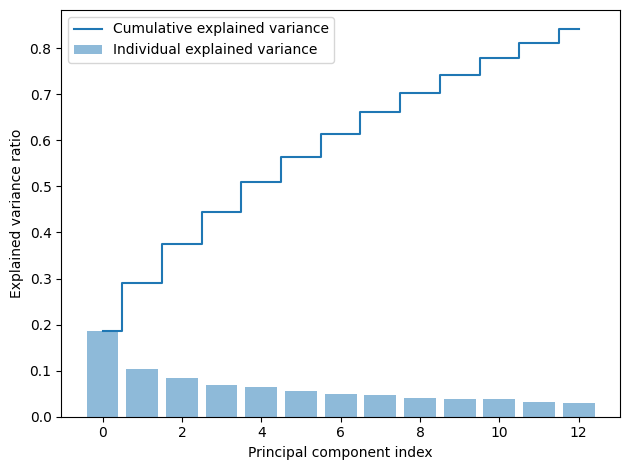

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import numpy as np 

pca = PCA(n_components=13)

#
X_train_pca = pca.fit_transform(X_Numerical_sc)

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)


plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [19]:
X_train_pca.shape
columns_pca = [f"C{idx}" for idx in range(13) ]
X_PCA = pd.DataFrame(X_train_pca,columns=columns_pca)


In [20]:
cum_sum_eigenvalues

array([0.18715969, 0.29103669, 0.37435815, 0.44389889, 0.5088901 ,
       0.56445741, 0.61422666, 0.6615947 , 0.70231383, 0.74104321,
       0.77872896, 0.8115653 , 0.84095978])

In [21]:
X_cat = ton_iot[categorical_feature]

# Optimize the features

### L4_SRC_PORT & L4_DST_PORT

Ports with numbers 0–1023 are called system or well-known ports; ports with numbers 1024-49151 are called user or registered ports, and ports with numbers 49152-65535 are called dynamic, private or ephemeral ports.[2] Both system and user ports are used by transport protocols (TCP, UDP, DCCP, SCTP) to identify an application or service.

In [22]:
well_known_port = list(range(1024))
registered_ports = list(range(1024,49152))
ephemeral_ports = list(range(49152,65535))

In [23]:
X_cat['L4_SRC_PORT_C'] = 'Others'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(well_known_port)] = 'well_known_port'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(registered_ports)] = 'registered_ports'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(ephemeral_ports)] = 'ephemeral_ports'

X_cat.drop(columns=['L4_SRC_PORT'],inplace=True)

X_cat['L4_SRC_PORT_C'].value_counts()

print(X_cat.shape)

(16940496, 10)


In [24]:
X_cat['L4_DST_PORT_C'] = 'Others'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(well_known_port)] = 'well_known_port'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(registered_ports)] = 'registered_ports'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(ephemeral_ports)] = 'ephemeral_ports'

X_cat.drop(columns=['L4_DST_PORT'],inplace=True)
X_cat['L4_DST_PORT_C'].value_counts()


L4_DST_PORT_C
well_known_port     9232384
registered_ports    6540544
ephemeral_ports     1167508
Others                   60
Name: count, dtype: int64

#### Removerd features are :

to_drop_zero = ['RETRANSMITTED_IN_BYTES','RETRANSMITTED_IN_PKTS','RETRANSMITTED_OUT_BYTES','FTP_COMMAND_RET_CODE','ICMP_TYPE','DNS_TTL_ANSWER']
&&

['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS', 'ICMP_IPV4_TYPE']

## DNS

In [25]:
X_cat['DNS_QUERY_TYPE'] = X_cat['DNS_QUERY_TYPE'].astype('O')
list_proto = [0,1,2,12]
X_cat['DNS_QUERY_TYPE'][~X_cat['DNS_QUERY_TYPE'].isin(list_proto)] = 'Other'
X_cat['DNS_QUERY_TYPE'].value_counts()

DNS_QUERY_TYPE
0        14542314
1         1568107
Other      744822
12          80496
2            4757
Name: count, dtype: int64

### PROTOCOL

In [26]:
X_cat['PROTOCOL'] = X_cat['PROTOCOL'].astype(int)

X_cat['PROTOCOL'].value_counts()

PROTOCOL
6     14427073
17     2491336
1        17933
2         2912
58        1241
44           1
Name: count, dtype: int64

In [27]:
print(X_cat.shape)

(16940496, 10)


In [28]:
X_cat['PROTOCOL'].value_counts()

PROTOCOL
6     14427073
17     2491336
1        17933
2         2912
58        1241
44           1
Name: count, dtype: int64

### L7_PROTO

In [29]:
X_cat['L7_PROTO'] = X_cat['L7_PROTO'].astype('O')
list_proto = [0,7,91,7.178,1,92,131,5.178]
X_cat['L7_PROTO'][~X_cat['L7_PROTO'].isin(list_proto)] = 'Other'
X_cat['L7_PROTO'].value_counts()

L7_PROTO
0.0      10290531
7.0       3999392
91.0      1732694
Other      489304
7.178      199531
1.0        131682
92.0        38579
131.0       30118
5.178       28665
Name: count, dtype: int64

#### Adresses

### Adress Range

In [30]:
# Private adresses
# Class A: 10.0.0.0 to 10.255.255.255
# Class B: 172.16.0.0 to 172.31.255.255
# Class C: 192.168.0.0 to 192.168.255.255
from ipaddress import ip_address


def findIPs(start, end):
    start = ip_address(start)
    end = ip_address(end)
    result = []
    while start <= end:
        result.append(str(start))
        start += 1
    return result
print('classe_a process ------------------------------->')
plage_classe_a=findIPs('10.0.0.0', '10.255.255.255')
print('classe_b process ------------------------------->')
plage_classe_b=findIPs('172.16.0.0', '172.31.255.255')
print('classe_c process ------------------------------->')
plage_classe_c=findIPs('192.168.0.0', '192.168.255.255')

classe_a process ------------------------------->
classe_b process ------------------------------->
classe_c process ------------------------------->


In [31]:
import numpy as np
X_cat['IPV4_DST_ADDR_CLASSE'] = 'None'
print('classe_c process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_c)] = 'classe_c'
print('classe_b process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_b)] = 'classe_b'
print('classe_a process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_a)] = 'classe_a'
print('localhost process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'] == '127.0.0.1'] = 'localhost'
print('public/other process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR_CLASSE'] == 'None'] = 'public/other'
X_cat['IPV4_DST_ADDR_CLASSE'].value_counts()

classe_c process ------------------------------->
classe_b process ------------------------------->
classe_a process ------------------------------->
localhost process ------------------------------->
public/other process ------------------------------->


IPV4_DST_ADDR_CLASSE
classe_c        16006162
public/other      929617
localhost           4700
classe_b              13
classe_a               4
Name: count, dtype: int64

In [32]:
import numpy as np
X_cat['IPV4_SRC_ADDR_CLASSE'] = 'None'
print('classe_c process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_c)] = 'classe_c'
print('classe_b process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_b)] = 'classe_b'
print('classe_a process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_a)] = 'classe_a'
print('localhost process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'] == '127.0.0.1'] = 'localhost'
print('public/other process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR_CLASSE'] == 'None'] = 'public/other'
X_cat['IPV4_SRC_ADDR_CLASSE'].value_counts()

classe_c process ------------------------------->
classe_b process ------------------------------->
classe_a process ------------------------------->
localhost process ------------------------------->
public/other process ------------------------------->


IPV4_SRC_ADDR_CLASSE
classe_c        16787988
classe_b          103646
public/other       44033
localhost           4706
classe_a             123
Name: count, dtype: int64

Remove IPV4_SRC_ADDR & IPV4_DST_ADDR and Keep IPV4_SRC_ADDR IPV4_DST_ADDR

In [33]:
X_cat.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)

## Optimze the 3 features ICMP_TYPE, ICMP_IPV4_TYPE, DNS_TTL_ANSWER

In [34]:
import math
infini = math.inf

X_cat['ICMP_TYPE'] = X_cat['ICMP_TYPE'].astype('O')
X_cat['ICMP_IPV4_TYPE'] = X_cat['ICMP_IPV4_TYPE'].astype('O')
X_cat['DNS_TTL_ANSWER'] = X_cat['DNS_TTL_ANSWER'].astype('O')

X_cat['ICMP_TYPE'][~(X_cat['ICMP_TYPE']==0)]=1
X_cat['ICMP_IPV4_TYPE'][~(X_cat['ICMP_IPV4_TYPE']==0)]=1
X_cat['DNS_TTL_ANSWER'][~(X_cat['DNS_TTL_ANSWER']==0)]=1

print(f"ICMPTYPE {X_cat['ICMP_TYPE'].value_counts()}, \n ICMP_IPV4_TYPE  {X_cat['ICMP_IPV4_TYPE'].value_counts()}, \n  DNS_TTL_ANSWER  {X_cat['DNS_TTL_ANSWER'].value_counts()}")



ICMPTYPE ICMP_TYPE
0    16658896
1      281600
Name: count, dtype: int64, 
 ICMP_IPV4_TYPE  ICMP_IPV4_TYPE
0    16658897
1      281599
Name: count, dtype: int64, 
  DNS_TTL_ANSWER  DNS_TTL_ANSWER
0    15833836
1     1106660
Name: count, dtype: int64


In [35]:
X_cat.head(4)

,PROTOCOL,L7_PROTO,DNS_QUERY_TYPE,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_TTL_ANSWER,L4_SRC_PORT_C,L4_DST_PORT_C,IPV4_DST_ADDR_CLASSE,IPV4_SRC_ADDR_CLASSE
0,6,0.0,0,0,0,0,ephemeral_ports,registered_ports,classe_c,classe_c
1,6,0.0,0,0,0,0,ephemeral_ports,registered_ports,classe_c,classe_c
2,1,0.0,0,1,1,0,well_known_port,well_known_port,classe_c,classe_c
3,17,0.0,0,0,0,0,ephemeral_ports,registered_ports,public/other,classe_c


# Feature Selection Filter-based

In [36]:
from sklearn.feature_selection import chi2

# Convert string values in categorical features to numerical
X_cat = X_cat.replace('Other',999)
X_cat = X_cat.replace('Others',999)
X_cat = X_cat.replace('well_known_port',0)
X_cat = X_cat.replace('registered_ports',1)
X_cat = X_cat.replace('ephemeral_ports',2)



X_cat = X_cat.replace('localhost',0)
X_cat = X_cat.replace('classe_a',1)
X_cat = X_cat.replace('classe_b',2)
X_cat = X_cat.replace('classe_c',3)
X_cat = X_cat.replace('public/other',4)


X_cat = X_cat.astype(int)



#X.dropna(inplace=True)

#X = X.astype(int)



In [ ]:
chi2_corr = chi2(X_cat,y_b)

In [38]:
columns_ranked_chi2 = list(X_cat.columns[np.argsort(-chi2_corr[0])])

In [37]:
#columns_ranked_chi2 = list(X_cat.columns[np.argsort(-chi2_corr[0])])
columns_ranked_chi2 = ['DNS_QUERY_TYPE',
 'L7_PROTO',
 'L4_DST_PORT_C',
 'PROTOCOL',
 'ICMP_IPV4_TYPE',
 'ICMP_TYPE',
 'L4_SRC_PORT_C',
 'DNS_TTL_ANSWER',
 'IPV4_DST_ADDR_CLASSE',
 'IPV4_SRC_ADDR_CLASSE']

## Ranking of features using CHI2

# We will select 3 pourcentage from the rest of the features
categorical
- 8.0
- 5.0
- 2.0

### Generate the 3 databases for chi 2

In [38]:
X_chi2_20 = X_cat[columns_ranked_chi2[:2]]
X_chi2_50 =  X_cat[columns_ranked_chi2[:5]]
X_chi2_80 =  X_cat[columns_ranked_chi2[:8]]

dummy_feature = ['L4_SRC_PORT_C','L4_DST_PORT_C','IPV4_SRC_ADDR_CLASSE',
                 'IPV4_DST_ADDR_CLASSE','PROTOCOL','L7_PROTO']
list_dummy_20 = list(set( list(X_chi2_20.columns)).intersection(dummy_feature))
list_dummy_50 = list(set( list(X_chi2_50.columns)).intersection(dummy_feature))
list_dummy_80 = list(set( list(X_chi2_80.columns)).intersection(dummy_feature))


X_chi2_20 = pd.get_dummies(X_chi2_20, columns=list_dummy_20)
X_chi2_50 = pd.get_dummies(X_chi2_50, columns=list_dummy_50)
X_chi2_80 = pd.get_dummies(X_chi2_80, columns=list_dummy_80)

# MUTUAL INFORMATION

In [40]:
from sklearn.feature_selection import mutual_info_classif

mi_class = mutual_info_classif(X_cat, y_b)


In [41]:
list(X_cat.columns[np.argsort(-mi_class)])

['L4_DST_PORT_C',
 'L7_PROTO',
 'L4_SRC_PORT_C',
 'DNS_QUERY_TYPE',
 'DNS_TTL_ANSWER',
 'ICMP_IPV4_TYPE',
 'ICMP_TYPE',
 'PROTOCOL',
 'IPV4_DST_ADDR_CLASSE',
 'IPV4_SRC_ADDR_CLASSE']

In [42]:
columns_ranked_mi = list(X_cat.columns[np.argsort(-mi_class)])

In [39]:
#columns_ranked_mi = list(X_cat.columns[np.argsort(-mi_class)])
columns_ranked_mi = ['L4_DST_PORT_C',
 'L7_PROTO',
 'L4_SRC_PORT_C',
 'DNS_TTL_ANSWER',
 'ICMP_TYPE',
 'ICMP_IPV4_TYPE',
 'PROTOCOL',
 'DNS_QUERY_TYPE',
 'IPV4_DST_ADDR_CLASSE',
 'IPV4_SRC_ADDR_CLASSE']

In [40]:
columns_ranked_mi

['L4_DST_PORT_C',
 'L7_PROTO',
 'L4_SRC_PORT_C',
 'DNS_TTL_ANSWER',
 'ICMP_TYPE',
 'ICMP_IPV4_TYPE',
 'PROTOCOL',
 'DNS_QUERY_TYPE',
 'IPV4_DST_ADDR_CLASSE',
 'IPV4_SRC_ADDR_CLASSE']

In [41]:
X_MI_20 = X_cat[columns_ranked_mi[:2]]
X_MI_50 =  X_cat[columns_ranked_mi[:5]]
X_MI_80 =  X_cat[columns_ranked_mi[:8]]

list_dummy_20 = list(set( list(X_MI_20.columns)).intersection(dummy_feature))
list_dummy_50 = list(set( list(X_MI_50.columns)).intersection(dummy_feature))
list_dummy_80 = list(set( list(X_MI_80.columns)).intersection(dummy_feature))


X_MI_20 = pd.get_dummies(X_MI_20, columns=list_dummy_20)
X_MI_50 = pd.get_dummies(X_MI_50, columns=list_dummy_50)
X_MI_80 = pd.get_dummies(X_MI_80, columns=list_dummy_80)

## mRMR

In [42]:
from mrmr import mrmr_classif
selected_features_20 = mrmr_classif(X=X_cat, y=y_b, K=2)
selected_features_50 = mrmr_classif(X=X_cat, y=y_b, K=5)
selected_features_80 = mrmr_classif(X=X_cat, y=y_b, K=8)

100%|█████████████████████████████████████████████| 8/8 [00:18<00:00,  2.30s/it]


In [43]:
X_mrmr_80 = X_cat[selected_features_80]
X_mrmr_50 = X_cat[selected_features_50]
X_mrmr_20 = X_cat[selected_features_20]

list_dummy_20 = list(set( list(X_mrmr_20.columns)).intersection(dummy_feature))
list_dummy_50 = list(set( list(X_mrmr_50.columns)).intersection(dummy_feature))
list_dummy_80 = list(set( list(X_mrmr_80.columns)).intersection(dummy_feature))

X_mrmr_20 = pd.get_dummies(X_mrmr_20, columns=list_dummy_20)
X_mrmr_50 = pd.get_dummies(X_mrmr_50, columns=list_dummy_50)
X_mrmr_80 = pd.get_dummies(X_mrmr_80, columns=list_dummy_80)

In [44]:
selected_features_80

['L4_DST_PORT_C',
 'DNS_QUERY_TYPE',
 'IPV4_SRC_ADDR_CLASSE',
 'L7_PROTO',
 'IPV4_DST_ADDR_CLASSE',
 'PROTOCOL',
 'ICMP_IPV4_TYPE',
 'L4_SRC_PORT_C']

In [45]:
import matplotlib.pyplot as plt

mi_scores = -np.sort(-mi_class)
feature_names = columns_ranked_mi

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(feature_names)), mi_scores, align='center')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information Scores for Feature Selection")

# Add MI score values at the top of each bar
for bar, score in zip(bars, mi_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(score, 3),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

NameError: name 'mi_class' is not defined

In [46]:
import matplotlib.pyplot as plt

chi2_scores = -np.sort(-chi2_corr[0])
feature_names_chi2 = columns_ranked_chi2

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(feature_names_chi2)), chi2_scores, align='center')
plt.xticks(range(len(feature_names_chi2)), feature_names_chi2, rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("CHI2 Score")
plt.title("Q squard Scores for Feature Selection")

# Add MI score values at the top of each bar
for bar, score in zip(bars, mi_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(score, 3),
             ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()

NameError: name 'chi2_corr' is not defined

In [46]:
import pickle

class Company(object):
    def __init__(self, name, value):
        self.name = name
        self.value = value

with open('attribute/ton_num.pkl', 'wb') as outp:
    company1 = Company('mi_class', mi_class)
    pickle.dump(company1, outp, pickle.HIGHEST_PROTOCOL)

    company2 = Company('selected_features_80', selected_features_80)
    pickle.dump(company2, outp, pickle.HIGHEST_PROTOCOL)
    
    company3 = Company('chi2_corr', chi2_corr)
    pickle.dump(company3, outp, pickle.HIGHEST_PROTOCOL)
    
    company4 = Company('sorted_kendall_tau_scores', sorted_kendall_tau_scores)
    pickle.dump(company4, outp, pickle.HIGHEST_PROTOCOL)
    
    company5 = Company('sb_anova', sb)
    pickle.dump(company5, outp, pickle.HIGHEST_PROTOCOL)


### Decision Tree

### MI

In [45]:
import json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [60]:
from sklearn import tree
from sklearn.model_selection import KFold
import json
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,cohen_kappa_score,matthews_corrcoef


def my_grid_result_df(clf,hyperparams,data_name,algo_name,X,y):
    
    scoring = {"Accuracy": "accuracy", "F1-Score":'f1' ,"Recall": 'recall',
               "Precision":"precision","MCC":make_scorer(matthews_corrcoef), "Kappa":make_scorer(cohen_kappa_score)}
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    search = GridSearchCV(clf, hyperparams, scoring=scoring, n_jobs=1, cv=cv_inner, refit="MCC")
    grid_result = search.fit(X, y)

    json_dump = json.dumps(grid_result.cv_results_,cls=NumpyEncoder)
    # Serializing json

    # Writing to sample.json
    with open(f"./result_ton_num_bin/{algo_name}__{data_name}.json", "w") as outfile:
        outfile.write(json_dump)


In [50]:
X_A_20.shape

(16940496, 5)

In [51]:
X_A_chi2_20 = pd.concat([X_A_20,X_chi2_20],axis=1)
X_A_chi2_20.shape

(16940496, 14)

In [48]:
X_A_chi2_20 = pd.concat([X_A_20,X_chi2_20],axis=1)
X_A_chi2_50 = pd.concat([X_A_50,X_chi2_50],axis=1)
X_A_chi2_80 = pd.concat([X_A_80,X_chi2_80],axis=1)

X_A_MI_20 = pd.concat([X_A_20,X_MI_20],axis=1)
X_A_MI_50= pd.concat([X_A_50,X_MI_50],axis=1)
X_A_MI_80= pd.concat([X_A_80,X_MI_80],axis=1)

X_A_mRMR_20 = pd.concat([X_A_20,X_mrmr_20],axis=1)
X_A_mRMR_50 = pd.concat([X_A_50,X_mrmr_50],axis=1)
X_A_mRMR_80 = pd.concat([X_A_80,X_mrmr_80],axis=1)

X_K_chi2_20 = pd.concat([X_K_20,X_chi2_20],axis=1)
X_K_chi2_50 = pd.concat([X_K_50,X_chi2_50],axis=1)
X_K_chi2_80 = pd.concat([X_K_80,X_chi2_80],axis=1)

X_K_MI_20 = pd.concat([X_K_20,X_MI_20],axis=1)
X_K_MI_50 = pd.concat([X_K_50,X_MI_50],axis=1)
X_K_MI_80 = pd.concat([X_K_80,X_MI_80],axis=1)

X_K_mRMR_20 = pd.concat([X_K_20,X_mrmr_20],axis=1)
X_K_mRMR_50 = pd.concat([X_K_50,X_mrmr_50],axis=1)
X_K_mRMR_80 = pd.concat([X_K_80,X_mrmr_80],axis=1)

X_PCA_chi2  = pd.concat([X_PCA,X_chi2_80],axis=1)
X_PCA_MI = pd.concat([X_PCA,X_MI_80],axis=1)
X_PCA_mRMR = pd.concat([X_PCA,X_mrmr_80],axis=1)

In [49]:
print(X_A_chi2_20.shape)
print(X_A_chi2_50.shape)
print(X_A_chi2_80.shape)
print(X_A_MI_20.shape)
print(X_A_MI_50.shape)
print(X_A_MI_80.shape)
print(X_A_mRMR_20.shape)
print(X_A_mRMR_50.shape)
print(X_A_mRMR_80.shape)
print(X_K_chi2_20.shape)
print(X_K_chi2_50.shape)
print(X_K_chi2_80.shape)
print(X_K_MI_20.shape)
print(X_K_MI_50.shape)
print(X_K_MI_80.shape)
print(X_K_mRMR_20.shape)
print(X_K_mRMR_50.shape)
print(X_K_mRMR_80.shape)
print(X_PCA_chi2.shape)
print(X_PCA_MI.shape)
print(X_PCA_mRMR.shape)

(16940496, 14)
(16940496, 33)
(16940496, 46)
(16940496, 17)
(16940496, 31)
(16940496, 46)
(16940496, 10)
(16940496, 36)
(16940496, 54)
(16940496, 14)
(16940496, 33)
(16940496, 46)
(16940496, 17)
(16940496, 31)
(16940496, 46)
(16940496, 10)
(16940496, 36)
(16940496, 54)
(16940496, 39)
(16940496, 39)
(16940496, 47)


In [55]:


dummy_feature = ['L4_SRC_PORT_C','L4_DST_PORT_C','IPV4_SRC_ADDR_CLASSE',
                 'IPV4_DST_ADDR_CLASSE','PROTOCOL','L7_PROTO']
X_cat_dm = pd.get_dummies(X_cat, columns=dummy_feature)
X =  pd.concat([X_Numerical_sc,X_cat_dm],axis=1)
X.shape

(16940496, 61)

In [56]:
datasets = {"X_A_chi2_20":X_A_chi2_20,
"X_A_chi2_50":X_A_chi2_50,
"X_A_chi2_80":X_A_chi2_80,
"X_A_MI_20":X_A_MI_20,
"X_A_MI_50":X_A_MI_50,
"X_A_MI_80":X_A_MI_80,
"X_A_mRMR_20":X_A_mRMR_20,
"X_A_mRMR_50":X_A_mRMR_50,
"X_A_mRMR_80":X_A_mRMR_80,
"X_K_chi2_20":X_K_chi2_20,
"X_K_chi2_50":X_K_chi2_50,
"X_K_chi2_80":X_K_chi2_80,
"X_K_MI_20":X_K_MI_20,
"X_K_MI_50":X_K_MI_50,
"X_K_MI_80":X_K_MI_80,
"X_K_mRMR_20":X_K_mRMR_20,
"X_K_mRMR_50":X_K_mRMR_50,
"X_K_mRMR_80":X_K_mRMR_80,
"X_PCA_chi2":X_PCA_chi2,
"X_PCA_MI":X_PCA_MI,
"X_PCA_mRMR":X_PCA_mRMR,
           "X":X}

In [61]:
import datetime
def create_all_result(clf,algo_name,hyperparams,datasets,y):
    for k,v in datasets.items():
        now = datetime.datetime.now()
        print(f'======== process======= dataset : {k} \t time is {now}')
        my_grid_result_df(clf,hyperparams,k,algo_name,v,y)
        now = datetime.datetime.now()
        print(f'======== Done  ======== dataset : {k} \t time is {now}')
        print('\n')


# Decision Tree

In [86]:
clf = tree.DecisionTreeClassifier()
hyperparams = {}
create_all_result(clf,'DecisionTreeClassifier',hyperparams,datasets,y_b)

======== process======= dataset : X_A_chi2_20 	 time is 2023-03-11 13:01:27.885369
======== Done  ======== dataset : X_A_chi2_20 	 time is 2023-03-11 13:03:20.267309


======== process======= dataset : X_A_chi2_50 	 time is 2023-03-11 13:03:20.267309
======== Done  ======== dataset : X_A_chi2_50 	 time is 2023-03-11 13:10:09.031304


======== process======= dataset : X_A_chi2_80 	 time is 2023-03-11 13:10:09.031304
======== Done  ======== dataset : X_A_chi2_80 	 time is 2023-03-11 13:23:15.800159


======== process======= dataset : X_A_MI_20 	 time is 2023-03-11 13:23:15.800159
======== Done  ======== dataset : X_A_MI_20 	 time is 2023-03-11 13:25:49.004255


======== process======= dataset : X_A_MI_50 	 time is 2023-03-11 13:25:49.004255
======== Done  ======== dataset : X_A_MI_50 	 time is 2023-03-11 13:34:17.582271


======== process======= dataset : X_A_MI_80 	 time is 2023-03-11 13:34:17.582271
======== Done  ======== dataset : X_A_MI_80 	 time is 2023-03-11 13:45:56.523527


====

In [55]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'positive_likelihood_ratio', 'neg_negative_likelihood_ratio', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weig

### AdaBoostClassifier, GradientBoostingClassifier


In [62]:
def print_skip():
    print('\n')
    print('*************** \t ******************* \t ****************')
    print('*************** \t ******************* \t ****************')
    print('\n')
    


In [ ]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import  CatBoostClassifier
from xgboost import  XGBClassifier


clf = GradientBoostingClassifier(random_state=0)
hyperparams = {'n_estimators':[50, 100, 150,200]}

print('======================= GradientBoostingClassifier =====================')
create_all_result(clf,'GradientBoostingClassifier',hyperparams,datasets,y_b)
print_skip()

print('======================= AdaBoostClassifier =====================')
clf =  AdaBoostClassifier(random_state=0)
create_all_result(clf,'AdaBoostClassifier',hyperparams,datasets,y_b)
print_skip()


print('======================= XGBClassifier =====================')
clf = XGBClassifier(random_state=0)
create_all_result(clf,'XGBClassifier',hyperparams,datasets,y_b)
print_skip()

print('======================= LGBMClassifier =====================')
clf = LGBMClassifier(random_state=0)
create_all_result(clf,'LGBMClassifier',hyperparams,datasets,y_b)
print_skip()

print('======================= CatBoostClassifier =====================')
clf =  CatBoostClassifier(random_state=0)
create_all_result(clf,'CatBoostClassifier',hyperparams,datasets,y_b)


======================= GradientBoostingClassifier =====================
======== process======= dataset : X_A_chi2_20 	 time is 2023-04-02 14:50:59.791138


## Build the model and save it 

In [57]:
# Best Model using  descritization  20 K-MI-XB200    X_k_MI_20 ||| 50 A-mRMR-XB200  X_A_mRMR_50 ||  80 A-mRMR-XB200  X_A_mRMR_80 ||  100 XGB_200  X

import xgboost as xgb

# Train your model (example)
model = xgb.XGBClassifier(n_estimators=200)
model.fit(X, y_b)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [58]:
import joblib

# Save
joblib.dump(model, "XGB_200.pkl")

['XGB_200.pkl']

In [59]:
print(list(X.iloc[0].values))
print(list(X.iloc[345].values))
print(list(X.iloc[6546].values))
print(list(X.iloc[23].values))
print(list(X.iloc[87].values))
print(list(X.iloc[9].values))
print(list(X.iloc[678].values))
print(list(X.iloc[0].values))
print(list(X.iloc[235].values))
print(list(X.iloc[98].values))

[np.float64(1.0791795682806162), np.float64(0.3842366032165473), np.float64(0.33124044040322775), np.float64(0.5648651671224987), np.float64(0.9925335922614721), np.float64(2.1017405191602645), np.float64(-0.15122658756126733), np.float64(-0.149942578972266), np.float64(3.057105373812355), np.float64(2.538891420926413), np.float64(-0.5050465972942744), np.float64(0.30197977239632917), np.float64(0.003923774175697326), np.float64(0.003901461369069576), np.float64(-0.006940315533259173), np.float64(-0.010179835723820684), np.float64(-0.012089743896783777), np.float64(7.199469573738197), np.float64(0.8012708760581772), np.float64(-0.010760010199871214), np.float64(4.231522537166005), np.float64(1.6283187412699602), np.float64(0.6819013122426192), np.float64(2.577450314448892), np.float64(-0.3085695169187371), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.False_, np.False_, np.True_, np.False_, np.False_, np.True_, np.False_, np.False_, np.False_, np.False_, np.False_, np.True_, n